In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [91]:
class PositionalEncoding(nn.Module):
    '''Positional Encoding'''
    def __init__(self, seq_len, d_model):
        super().__init__()
        self.positional_enconding = nn.Parameter(torch.randn(1, seq_len, d_model))

    def forward(self, x):
        return x + self.positional_enconding


## __init__ Method
self.positional_enconding is defined as a learnable parameter with the shape (1, seq_len, d_model). This tensor is initialized with random values using torch.randn

Shape: (1, seq_len, d_model)
1: The batch dimension is set to 1 because the positional encoding is intended to be broadcasted across different batches.
seq_len: The length of the sequence. Each position in the sequence will have a unique encoding.
d_model: The dimensionality of the model or embedding size.

## forward Method
Input Tensor x:

The input tensor x should have the shape (batch_size, seq_len, d_model). It represents the input data where batch_size is the number of sequences in a batch, seq_len is the length of each sequence, and d_model is the dimensionality of each element in the sequence.
Addition of Positional Encoding:

The operation x + self.positional_enconding adds the positional encoding to the input tensor x.
Broadcasting: The shape of self.positional_enconding is (1, seq_len, d_model), so it will be broadcasted across the batch dimension of x (which is (batch_size, seq_len, d_model)). This means that the same positional encoding will be added to each sequence in the batch.

Purpose: The PositionalEncoding class is designed to add positional information to the input sequences. This helps the model to distinguish between different positions in the sequence, which is crucial for sequence models like Transformers that do not inherently capture the order of tokens.

Mechanism: The positional encoding is initialized as a learnable parameter and added to the input tensor x. The encoding tensor has the shape (1, seq_len, d_model) and is broadcasted to match the batch size of x.

Effect: By adding positional encodings to the input, the model gains information about the position of each token in the sequence, which improves its ability to learn and represent sequential relationships.

In [95]:
class SelfAttentionModel(nn.Module):
    def __init__(self, seq_len, d_model, n_heads):
        super().__init__()
        self.positional_encoding = PositionalEncoding(seq_len, d_model)
        self.attention = nn.MultiheadAttention(embed_dim = d_model, num_heads = n_heads)
        self.fc = nn.Linear(d_model,1)

    def forward(self, x):
        x = self.positional_encoding(x)
        x = x.transpose(0,1)
        attn_output, _ = self.attention(x,x,x)
        attn_output = attn_output.mean(dim = 0)
        output = self.fc(attn_output)
        return output

Self-Attention Layer:

python
Copy code
self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads)
Initializes a multi-head self-attention layer. This layer computes the attention scores between different positions in the sequence and combines information from multiple attention heads.
Parameters:
embed_dim: Dimensionality of the embeddings (same as d_model).
num_heads: Number of attention heads to use.

Linear Layer:

python
Copy code
self.fc = nn.Linear(d_model, 1)
Defines a fully connected (linear) layer that maps the output of the self-attention layer to a single output value.
Parameters:
d_model: Input dimension (same as the output dimension of the self-attention layer).
1: Output dimension (single value per sequence).
forward Method
Applying Positional Encoding:

python
Copy code
x = self.positional_encoding(x)
Adds positional encoding to the input tensor x. This helps the model incorporate the position of each token in the sequence.

Applying Self-Attention:

python
Copy code
attn_output, _ = self.attention(x, x, x)
Applies the self-attention layer to the input tensor x.
Parameters:
The three arguments (x, x, x) correspond to query, key, and value, respectively. In self-attention, these are usually the same.
Output:
attn_output: The output of the self-attention layer, containing attended information from all positions in the sequence.

Pooling and Linear Transformation:

python
Copy code
attn_output = attn_output.mean(dim=0)
output = self.fc(attn_output)
Pooling: Takes the mean of the self-attention output across the sequence length dimension (dim=0). This reduces the output to a single representation per batch.
Linear Transformation: Passes the pooled output through a fully connected layer (self.fc) to produce the final output. This maps the representation to a single value per sequence.

The SelfAttentionModel combines positional encoding and self-attention to process sequence data. It adds positional information to the input, applies multi-head self-attention to capture dependencies between different positions in the sequence, and then uses a linear layer to produce a single output value per sequence. This model is suitable for tasks where understanding the sequence and relationships between tokens is important.

In [93]:
def create_dummy_data(batch_size, seq_len, d_model):
    n = 0.01
    X = torch.randn(batch_size, seq_len, d_model) * n
    y = torch.randn(batch_size, 1)* n
    return X, y

Dummy Data Generator

In [65]:
seq_len = 10
d_model = 16
batch_size = 32
n_heads = 4

In [96]:
model = SelfAttentionModel(seq_len=seq_len, d_model=d_model, n_heads=n_heads)
loss_index = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

loss_item = []
num_epochs = 200
for epoch in range(num_epochs):
    X, y = create_dummy_data(batch_size, seq_len, d_model)

    optimizer.zero_grad()
    output = model(X)
    

    loss = loss_index(output, y)
    
    
    loss.backward()
    optimizer.step()
    loss_item.append(loss.item())
    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 20, Loss: 0.0093
Epoch 40, Loss: 0.0045
Epoch 60, Loss: 0.0020
Epoch 80, Loss: 0.0007
Epoch 100, Loss: 0.0002
Epoch 120, Loss: 0.0001
Epoch 140, Loss: 0.0001
Epoch 160, Loss: 0.0001
Epoch 180, Loss: 0.0001
Epoch 200, Loss: 0.0001


Creates an instance of the SelfAttentionModel with the specified sequence length (seq_len), model dimensionality (d_model), and number of attention heads (n_heads).
Loss Function:

python
Copy code
loss_index = nn.MSELoss()
Initializes the Mean Squared Error (MSE) loss function, which is used to compute the difference between the model's predictions and the true values.
Optimizer:

python
Copy code
optimizer = optim.Adam(model.parameters(), lr=0.0001)
Sets up the Adam optimizer with a learning rate of 0.0001. This optimizer adjusts the model’s weights to minimize the loss.
Training Loop:

X, y = create_dummy_data(batch_size, seq_len, d_model): Generates a batch of dummy data with the specified batch size, sequence length, and model dimensionality.

optimizer.zero_grad(): Clears the gradients from the previous step to prevent accumulation.

output = model(X): Passes the input data X through the model to get the predicted output.

loss = loss_index(output, y): Computes the loss between the predicted output and the true values y.

loss.backward(): Computes the gradient of the loss with respect to the model parameters.

optimizer.step(): Updates the model parameters based on the computed gradients.

In [56]:
import matplotlib.pyplot as plt

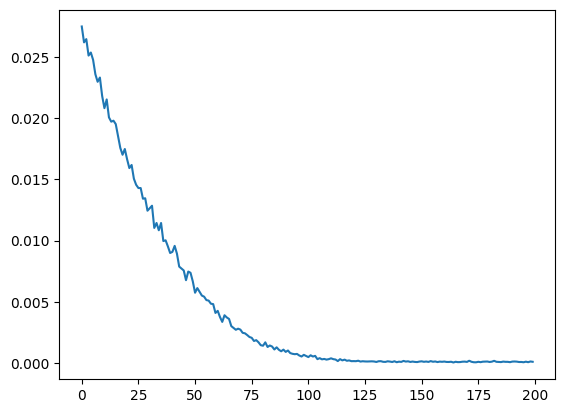

In [90]:
plt.plot(loss_item)